## Introduction


Segmentation — identifying which image pixels belong to an object — is a core task in computer vision and is used in a broad array of applications, from analyzing scientific imagery to editing photos. But creating an accurate segmentation model for specific tasks typically requires highly specialized work by technical experts with access to AI training infrastructure and large volumes of carefully annotated in-domain data.

source - https://ai.facebook.com/blog/segment-anything-foundation-model-image-segmentation/

First make sure pytorch and torchcvision are installed, for GPU
In my case: 
- pip install torch torchvision torchaudio
- pip install opencv-python matplotlib
- pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    - OR download the repo locally and install
    - and:  pip install -e .

- Download the default trained model: 
    - https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
- Other models are available:
    - https://github.com/facebookresearch/segment-anything#model-checkpoints


In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.0
Torchvision version: 0.15.1
CUDA is available: False


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

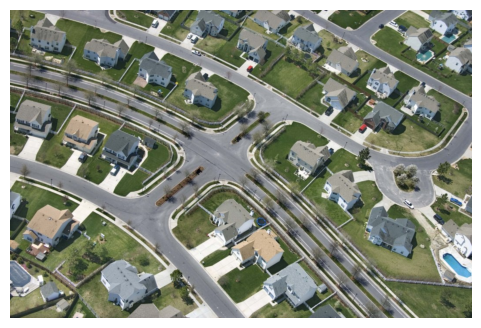

In [5]:
image = cv2.imread('houses.jpg')  #Try houses.jpg or neurons.jpg
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,4))
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [10]:
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)

- There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. 

- Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. 

- Here is an example configuration that samples more masks:
    - https://github.com/facebookresearch/segment-anything/blob/9e1eb9fdbc4bca4cd0d948b8ae7fe505d9f4ebc7/segment_anything/automatic_mask_generator.py#L35    


#### Parameters that we used from SamAutomaticMaskGenerator

`points_per_side` (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.

`pred_iou_thresh (float)`: A filtering threshold in [0,1], using the
            model's predicted mask quality.
          
`stability_score_thresh` (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.

`crops_n_layers` (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.

`crop_n_points_downscale_factor` (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.

`min_mask_region_area` (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.

In [11]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator_.generate(image)

print(len(masks))

296


> Length of masks tells that the numnber of objects detected, in our case it was 296 Objects

In [12]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

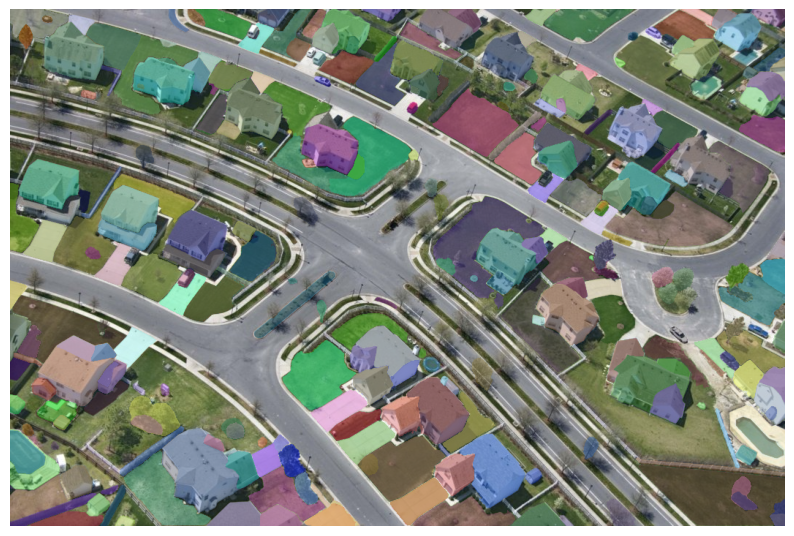

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

#### Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. 
These keys are:
- segmentation : the mask
- area : the area of the mask in pixels
- bbox : the boundary box of the mask in XYWH format
- predicted_iou : the model's own prediction for the quality of the mask
- point_coords : the sampled input point that generated this mask
- stability_score : an additional measure of mask quality
- crop_box : the crop of the image used to generate this mask in XYWH format

In [15]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 5680,
  'bbox': [578, 109, 116, 92],
  'predicted_iou': 0.9929327368736267,
  'point_coords': [[633.4375, 162.9375]],
  'stability_score': 0.9806552529335022,
  'crop_box': [410, 0, 650, 474]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 3403,
  'bbox': [730, 0, 1

Rerun with a few settings, ex. 0.86 & 0.9 for iou_thresh and 0.92 and 0.96 for score_thresh, the object detection will change

In [16]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator_.generate(image)

print(len(masks))

455


In [17]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

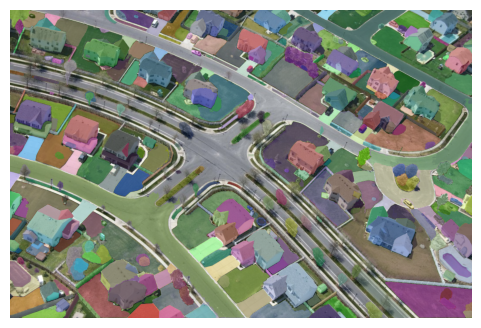

In [18]:
plt.figure(figsize=(6,4))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 